#Proyecto Final
##Diplomado Machine Laearning - UCOM PRO
###Universidad Comunera
Diciembre 2020
Orlando Chaparro
###Proyecto:
Detección Automática de Matriculas de Autovehículos
Usando técnicas de Machine Learning.

#Parte 2:
Detección y Segmentación de los Caráctares de las Matrículas utilizando OpenCV Procesando imágenes segmentadas cambiandolas de RGB a tonos de Grises, y Contrastándolas para detectar posibles caráteres.

In [1]:
# Importar Librerias
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob

#### Si va a probar desde Google Drive con Collab  
#### La notebook y datasets están todos en Googl Drive listos para ser probados  
#### si no desea probarlo en su entorno propio.


####Acceso al google Drive desde el Google collab 

In [2]:

from google.colab import drive
drive.mount('/content/drive/', 'force_remount=True')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/ucom')
from local_utils import detect_lp


Mounted at /content/drive/


#### Si esta usando Google Collab desde Google Drive.
#### Debe ejecutar esta linea para posicionarse en la carpeta del proyecto en Google Drive

In [3]:
cd 'drive/My Drive/Colab Notebooks/ucom'

/content/drive/My Drive/Colab Notebooks/ucom


In [ ]:
#Si va a usar su entorno propio, si bajó todo el proyecto o lo clonó de Github 
# descomentar la sgte. linea.
#from local_utils import detect_lp

#### Extrae la Chapa desde una imagen de ejemplo del directorio images  

In [4]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

#### Modelo WPOD-NET 
##Warped Planar Object Detection Network - Red de detección de objetos planos deformados
## Modelo pre-entrenado WPOD-NET 
##para la detección de la Zona Matrícula (Chapa) en la Imagen.

In [5]:
# En esta celda se ejecuta la carga del Modelo wpod-net 
# importante que salga el mensaje Loading model Successfully. 
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


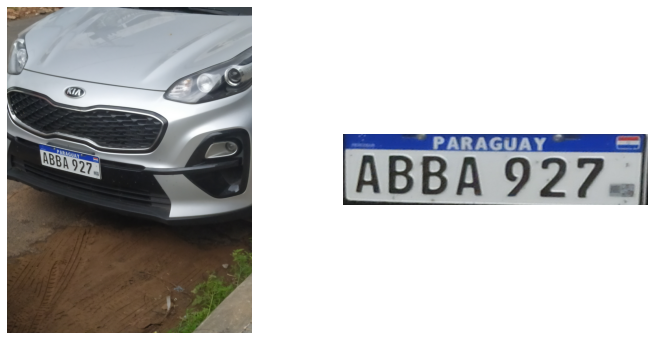

In [6]:
#Funcion de Prepoceso de la Imagen
# Reliza la lectura de la imagen, calbio de Esquema de Color RGB, redimensión
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

# Se indica el nombre de la imagen a ser procesada para detectar la Chapa

test_image_path = "images/chpy1.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

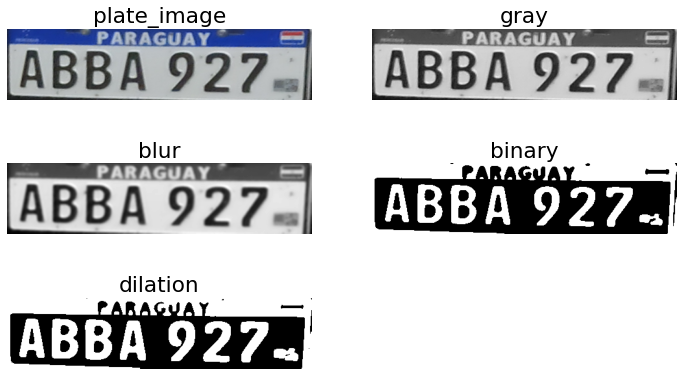

In [7]:
if (len(LpImg)): #Verifica si existe al menos una imagen
    # Scala, calcula valores absolutos y convierte el resutado a 8 bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # Convierte a Escala de Grises y Blur la imagen
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Aplica el efecto Inverso thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualiza resultados    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)

Se Detectan 7 Caracteres...


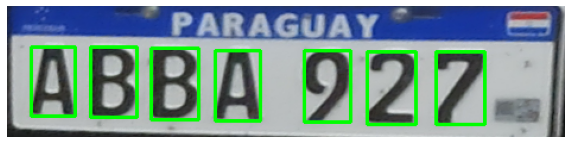

In [8]:
# Crea lafunción sort_contours() para obtener el contorno de cada Digito de Izquierda a Derecha
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crae una versión de copia "test_roi" REgion de interes de plat_image para dibujar las cajas de bordes
test_roi = plate_image.copy()

# Inicializa una lista el cual será usada para agrega imagenes de Carácteres
crop_characters = []

# define un standard ancho y alto de  Caracter
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Separa los numeros 
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Se Detectan {} Caracteres...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

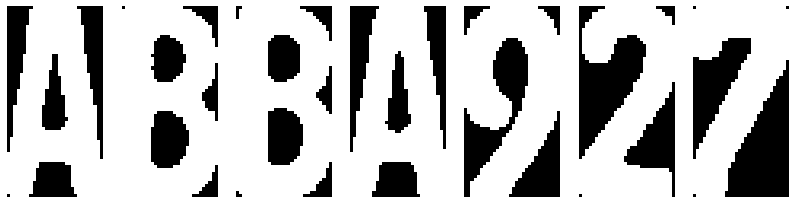

In [9]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)    

# Fin de la Segunda Parte